In [1]:
import pandas as pd
from pandas.plotting import parallel_coordinates
import os
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import LocalOutlierFactor
# import xgboost as xgb
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# Data Cleaning for Housing Listings

This notebook is dedicated to cleaning the housing dataset. The following tasks are performed:
1. Loading the dataset.
5. Renaming columns for clarity.


In [2]:
raw_housing_data = pd.read_csv("data/PrimaryDataset-MLS-RentalProperties.csv") # load the dataset

# Display basic information about the dataset
print(raw_housing_data.shape)
raw_housing_data.info()

# Display the first few rows of the dataset to inspect it
raw_housing_data.head()

(1749, 77)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1749 entries, 0 to 1748
Data columns (total 77 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   List Number                           1749 non-null   object 
 1   Agency Phone                          1736 non-null   object 
 2   Listing Agent                         1749 non-null   object 
 3   Co-Listing Agent                      285 non-null    object 
 4   Property Type                         1749 non-null   object 
 5   Card Format                           1749 non-null   object 
 6   Book Section                          1749 non-null   object 
 7   Property Sub Type                     1749 non-null   object 
 8   Listing Contract Date                 1749 non-null   object 
 9   Back on Market Date                   78 non-null     object 
 10  Status                                1749 non-null   object 
 11  Status

,List Number,Agency Phone,Listing Agent,Co-Listing Agent,Property Type,Card Format,Book Section,Property Sub Type,Listing Contract Date,Back on Market Date,...,Carport Spaces,Non-Representative Compensation,Entry Level,Accessibility Features YN,Unit Type,Comp Sale YN,Price Change Timestamp,Days on Market,Rooms,Features
0,gAAAAABm9wKyQ9Jkf67wT775NlUCIiB2uBl4wESoZ5GvSi...,Agency_Phone_Index_656,Listing_Agent_Index_974,NaN,Rental,Residential Lease,Townhouse,TH,3/2/24,NaN,...,NaN,0.0,1.0,N,NaN,N,NaN,137,NaN,Additional Lease Terms|12 Months|Yes;Deposits ...
1,gAAAAABm9wKysBww5tTVmO-0CpaE-LagSeR4KNGjc7knBz...,Agency_Phone_Index_657,Listing_Agent_Index_975,NaN,Rental,Residential Lease,Quadruplex,QU,6/3/24,NaN,...,NaN,0.0,NaN,N,NaN,NaN,9/22/24 1:37,65,NaN,Additional Lease Terms|12 Months|Yes;Deposits ...
2,gAAAAABm9wKyuy2g6q3NVvgVVN2exdWKr-5NmAsg3RNetA...,Agency_Phone_Index_658,Listing_Agent_Index_976,NaN,Rental,Residential Lease,Single Family Residence,SF,6/21/24,NaN,...,NaN,0.0,NaN,N,NaN,NaN,NaN,15,NaN,Additional Lease Terms|Other|Yes;Deposits and ...
3,gAAAAABm9wKybWr-f_0vG4kOlej1Gw_MwtKb3AMZPFNdte...,Agency_Phone_Index_659,Listing_Agent_Index_977,NaN,Rental,Residential Lease,Single Family Residence,SF,6/8/24,NaN,...,NaN,0.0,NaN,N,NaN,NaN,NaN,72,NaN,Additional Lease Terms|12 Months|Yes;Deposits ...
4,gAAAAABm9wKyUSN6Gk6V_nncQa-FWOF9jyeT36mywJscdR...,Agency_Phone_Index_660,Listing_Agent_Index_978,NaN,Rental,Residential Lease,Condominium,CN,6/6/24,NaN,...,NaN,0.0,NaN,N,NaN,NaN,NaN,57,NaN,Additional Fee Includes|Lease Prep|Yes;Additio...


In [3]:
relevant_columns = [
    'List Price', 'Bedrooms Total', 'Bathrooms Total', 'Living Area', 
    'MLS Area Major', 'Year Built', 
    'Lot Size Acres', 'Days on Market', 'Non-Representative Compensation',
    'Waterfront YN', 'Garage YN', 'Stories Total', 'Stories', 'Bedrooms Total', 'Bathrooms Total',
    'Bathrooms Full', 'Bathrooms Half', 'Garage YN', 'Garage Spaces', 'Original List Price', 'Latitude', 'Longitude', 'Rooms', 'Features'
]

numerical_columns = [
    'List Price', 'Bedrooms Total', 'Bathrooms Total', 'Living Area', 'MLS Area Major', 'Year Built', 'Lot Size Acres', 'Days on Market', 'Non-Representative Compensation',
    'Stories Total', 'Stories', 'Bathrooms Full', 'Bathrooms Half', 'Garage Spaces', 'Original List Price', 'Latitude', 'Longitude'
]

print(len(numerical_columns))

# Drop the irrelevant columns
cleaned_housing_data = raw_housing_data[numerical_columns]

17


In [4]:
# Drop rows with any missing values
cleaned_housing_data = cleaned_housing_data.dropna()

# Check for duplicate columns and remove them
cleaned_housing_data = cleaned_housing_data.loc[:, ~cleaned_housing_data.columns.duplicated()]

# Display the dataset shape and head after these operations
print(cleaned_housing_data.shape)
cleaned_housing_data.info()
cleaned_housing_data.head()

(340, 17)
<class 'pandas.core.frame.DataFrame'>
Index: 340 entries, 24 to 1745
Data columns (total 17 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   List Price                       340 non-null    int64  
 1   Bedrooms Total                   340 non-null    int64  
 2   Bathrooms Total                  340 non-null    int64  
 3   Living Area                      340 non-null    float64
 4   MLS Area Major                   340 non-null    int64  
 5   Year Built                       340 non-null    int64  
 6   Lot Size Acres                   340 non-null    float64
 7   Days on Market                   340 non-null    int64  
 8   Non-Representative Compensation  340 non-null    float64
 9   Stories Total                    340 non-null    float64
 10  Stories                          340 non-null    float64
 11  Bathrooms Full                   340 non-null    int64  
 12  Bathrooms Half 

,List Price,Bedrooms Total,Bathrooms Total,Living Area,MLS Area Major,Year Built,Lot Size Acres,Days on Market,Non-Representative Compensation,Stories Total,Stories,Bathrooms Full,Bathrooms Half,Garage Spaces,Original List Price,Latitude,Longitude
24,1695,2,2,1230.0,26,2008,0.01,55,10.0,2.0,2.0,2,0.0,1.0,1725,30.284262,-81.454856
26,2700,5,2,2498.0,14,1996,0.46,43,0.0,2.0,2.0,2,0.0,2.0,2900,30.156717,-81.629576
37,2500,5,2,1990.0,135,1980,0.27,53,100.0,1.0,1.0,2,0.0,2.0,2600,30.160414,-81.744717
39,4425,3,3,2442.0,43,2012,0.10,23,1.0,2.0,2.0,2,1.0,2.0,4425,30.341041,-81.461648
40,4500,3,2,1426.0,212,1979,0.14,21,1.0,2.0,2.0,2,0.0,1.0,4500,30.266153,-81.398813


In [5]:
# File path to save the CSV
file_path = 'data/cleaned_housing_data.csv'

# Check if the file already exists
if not os.path.exists(file_path):
    cleaned_housing_data.to_csv(file_path, index=False)
    print(f"File saved as {file_path}")
else:
    print(f"File {file_path} already exists. No action taken.")

File saved as data/cleaned_housing_data.csv



# Principal Component Analysis (PCA) and Anomaly Detection

In this section, we apply PCA for dimensionality reduction and anomaly detection on housing data.
We will retain 95% of variance and also explore anomaly detection using DBSCAN and Isolation Forest.

---

### Step 1: Fit PCA and Transform the Data
Here, we fit PCA to the scaled dataset and retain 95% of the variance.

In [6]:
# Step 1: Fit the PCA (retaining 95% of variance)
scaler = StandardScaler()
x_scaled = scaler.fit_transform(cleaned_housing_data)

print(x_scaled.shape)
pca_model = PCA(n_components=0.95)
x_pca = pca_model.fit_transform(x_scaled)  # 'x_scaled' is the scaled input data

(340, 17)



### Step 2: Create a DataFrame for the Principal Components

We create a DataFrame that contains the principal components for each data point.
Each component captures the variance in the original features.


In [7]:

# Create column names for PCA components
pca_columns = [f'PC{i+1}' for i in range(x_pca.shape[1])]

# Create a DataFrame for the PCA-transformed data
pca_df = pd.DataFrame(x_pca, columns=pca_columns)
pca_df.head()

model1 = IsolationForest(n_estimators=100, max_samples='auto', contamination='auto', random_state=12)

model1.fit(x_pca)

predict = model1.predict(x_pca)
anomalies = x_scaled[predict == -1]

(17, 13)
17


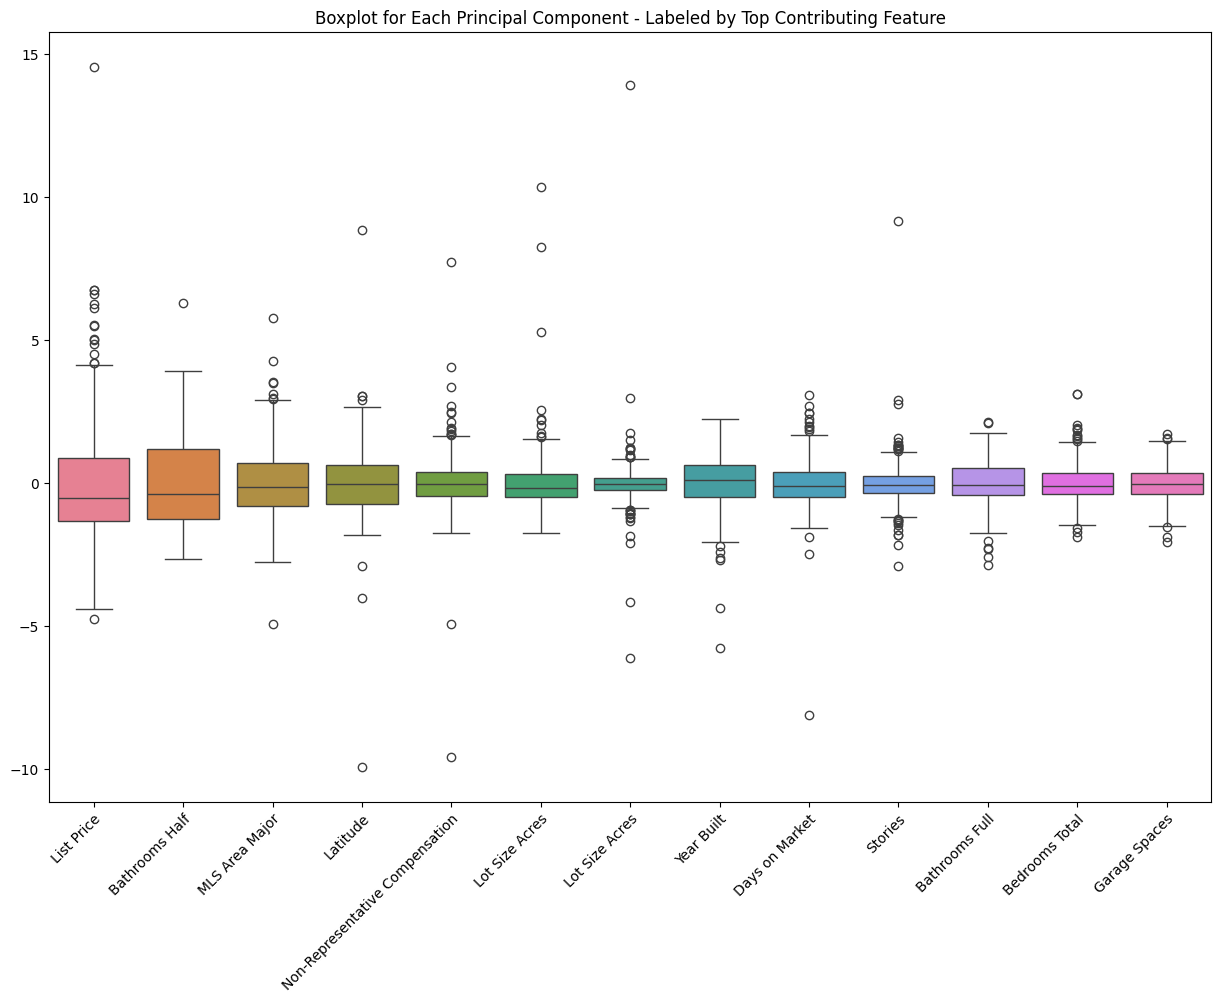

In [8]:
# Step 1: Fit the PCA as before
pca = PCA(n_components=0.95)  # Retaining 95% of variance
x_pca = pca.fit_transform(x_scaled)

# Step 2: Create a DataFrame for the principal components
pca_columns = [f'PC{i+1}' for i in range(x_pca.shape[1])] 
pca_df = pd.DataFrame(x_pca, columns=pca_columns)

# Step 3: Get the contributions of each original feature to each principal component
loadings = pca.components_.T  # Transpose to get original features as rows
print(loadings.shape)
print(len(numerical_columns))
contributions_df = pd.DataFrame(loadings, index=numerical_columns, columns=pca_columns)


# Step 4: Get the top contributing feature for each principal component (for labeling purposes)
top_features_per_pc = contributions_df.abs().idxmax()

# Step 5: Create a box plot and label each principal component by its strongest contributing original feature
plt.figure(figsize=(15, 10))
sns.boxplot(data=pca_df)

# Rotate the text diagonally and align it so it reads from top to bottom
plt.xticks(range(len(top_features_per_pc)), top_features_per_pc, rotation=45, ha="right", rotation_mode="anchor")

# Title
plt.title('Boxplot for Each Principal Component - Labeled by Top Contributing Feature')
plt.show()

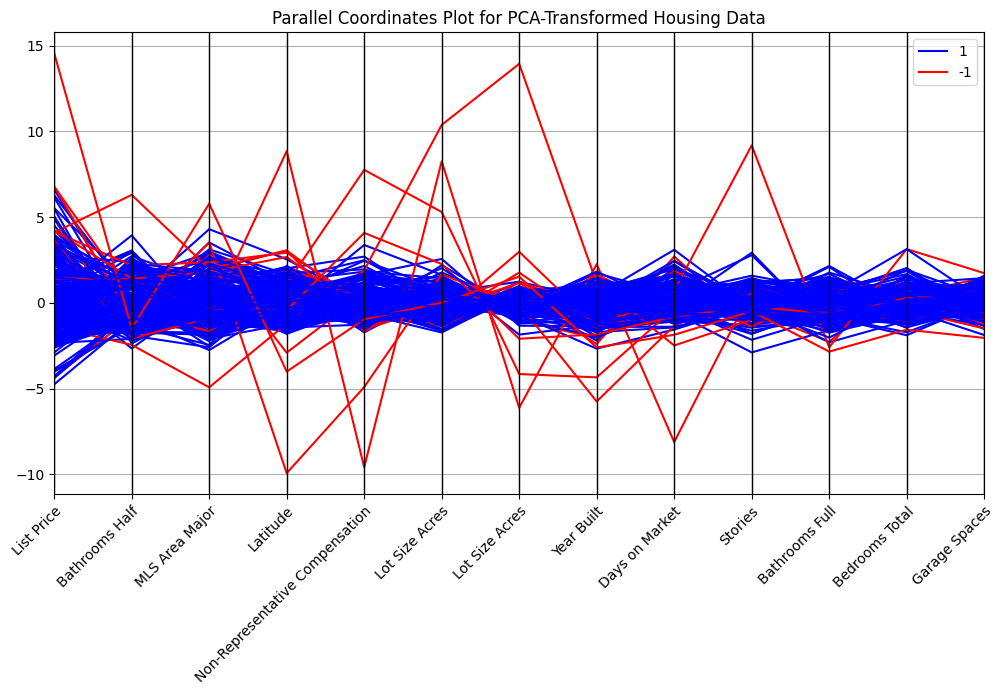

In [9]:
# Step 1: Fit the PCA as before
pca = PCA(n_components=0.95)  # Retaining 95% of variance
x_pca = pca.fit_transform(x_scaled)

# Step 2: Create a DataFrame for the principal components
pca_columns = [f'PC{i+1}' for i in range(x_pca.shape[1])]
pca_df = pd.DataFrame(x_pca, columns=pca_columns)

# Step 3: Get the contributions of each original feature to each principal component
loadings = pca.components_.T  # Transpose to get original features as rows
contributions_df = pd.DataFrame(loadings, index=numerical_columns, columns=pca_columns)

# Step 4: Get the top contributing feature for each principal component (for labeling purposes)
top_features_per_pc = contributions_df.abs().idxmax()

# Step 5: Add anomaly labels to the PCA DataFrame
pca_df['anomaly'] = predict  # Anomalies (-1) and normal points (1)

# Step 6: Parallel Coordinates Plot with PCA data and anomaly labels
plt.figure(figsize=(12, 6))
parallel_coordinates(pca_df, 'anomaly', color=['blue', 'red'])

# Step 7: Adjust the x-axis labels (principal components) with top contributing original feature names
plt.xticks(range(len(top_features_per_pc)), top_features_per_pc, rotation=45, ha="right", rotation_mode="anchor")

# Title
plt.title('Parallel Coordinates Plot for PCA-Transformed Housing Data')
plt.show()

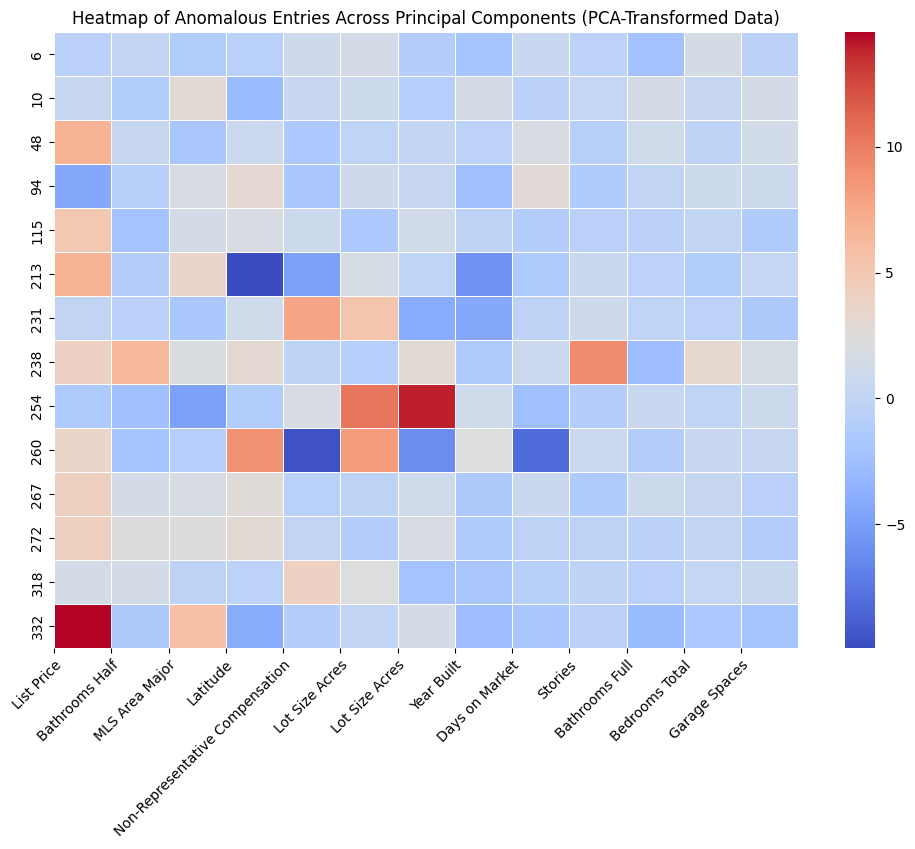

In [10]:
# Step 1: Fit the PCA as before
pca = PCA(n_components=0.95)  # Retaining 95% of variance
x_pca = pca.fit_transform(x_scaled)

# Step 2: Create a DataFrame for the principal components
pca_columns = [f'PC{i+1}' for i in range(x_pca.shape[1])]
pca_df = pd.DataFrame(x_pca, columns=pca_columns)

# Step 3: Get the contributions of each original feature to each principal component
loadings = pca.components_.T  # Transpose to get original features as rows
contributions_df = pd.DataFrame(loadings, index=numerical_columns, columns=pca_columns)

# Step 4: Get the top contributing feature for each principal component (for labeling purposes)
top_features_per_pc = contributions_df.abs().idxmax()

# Step 5: Filter the PCA data to show only anomalies (-1)
anomalous_data = pca_df[predict == -1]

# Step 6: Plot a heatmap of the anomalous entries (use PCA-transformed data)
plt.figure(figsize=(12, 8))
sns.heatmap(anomalous_data, cmap='coolwarm', annot=False, linewidths=0.5)

# Step 7: Adjust x-axis labels to reflect original features (diagonal or vertical)
plt.xticks(range(len(top_features_per_pc)), top_features_per_pc, rotation=45, ha="right", rotation_mode="anchor")

# Title
plt.title('Heatmap of Anomalous Entries Across Principal Components (PCA-Transformed Data)')
plt.show()

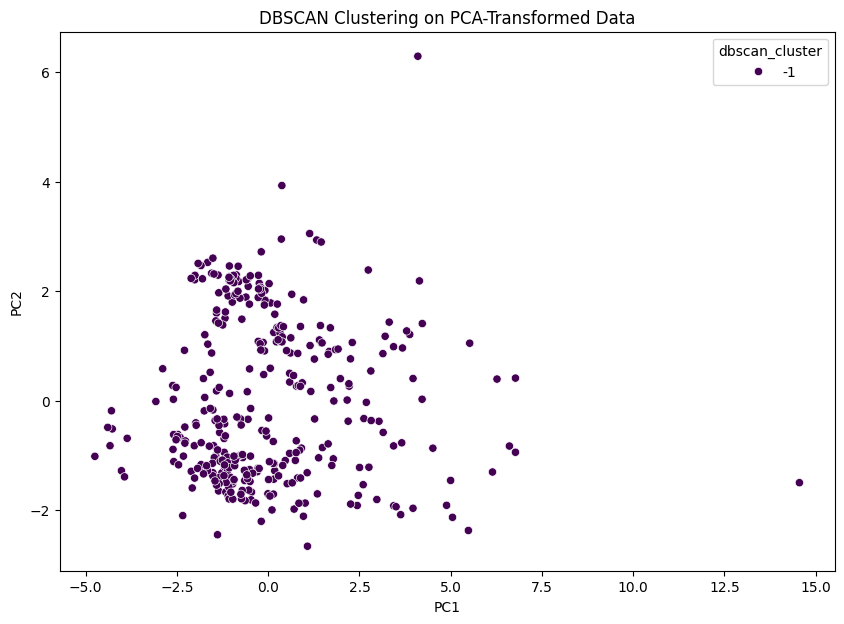

Number of points flagged by both DBSCAN and Isolation Forest: 0


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,dbscan_cluster,anomaly_iforest


In [11]:
# Step 1: Fit DBSCAN on the PCA-transformed data
dbscan_model = DBSCAN(eps=0.5, min_samples=5)  # Adjust eps and min_samples based on your data
dbscan_labels = dbscan_model.fit_predict(x_pca)

# Step 2: Add DBSCAN cluster labels to the PCA DataFrame
pca_df['dbscan_cluster'] = dbscan_labels

# Step 3: Visualize the clusters
plt.figure(figsize=(10, 7))
sns.scatterplot(x=pca_df['PC1'], y=pca_df['PC2'], hue=pca_df['dbscan_cluster'], palette='viridis')
plt.title('DBSCAN Clustering on PCA-Transformed Data')
plt.show()

# Step 4: Cross-examine DBSCAN clusters with Isolation Forest results
pca_df['anomaly_iforest'] = predict  # Add Isolation Forest anomaly labels (-1 for anomalies, 1 for normal)

# Compare clusters and anomalies
cross_examined = pca_df[(pca_df['dbscan_cluster'] != -1) & (pca_df['anomaly_iforest'] == -1)]

print(f"Number of points flagged by both DBSCAN and Isolation Forest: {len(cross_examined)}")
cross_examined

In [12]:
# Add the Over_30_Days_Flag (0 = 30 days or less, 1 = more than 90 days)
cleaned_housing_data['Over_30_Days_Flag'] = cleaned_housing_data['Days on Market'].apply(lambda x: 1 if x > 30 else 0)

# Save the updated dataset to a new CSV file with a better file name
file_path = 'data/housing_data_over_30_days_flag.csv'

# Check if the file already exists
if not os.path.exists(file_path):
    cleaned_housing_data.to_csv(file_path, index=False)
    print(f"File saved as {file_path}")
else:
    print(f"File {file_path} already exists. No action taken.")

# Verify the first few rows of the updated dataset
print(cleaned_housing_data[['Days on Market', 'Over_30_Days_Flag']].head(10))

File data/housing_data_over_30_days_flag.csv already exists. No action taken.
    Days on Market  Over_30_Days_Flag
24              55                  1
26              43                  1
37              53                  1
39              23                  0
40              21                  0
43               7                  0
44              48                  1
46              94                  1
51              36                  1
54               0                  0


In [13]:
import folium
from folium.plugins import HeatMap
from math import radians, cos, sin, asin, sqrt, log

# Important locationations for proximity scoring
important_coordinates = [
    {"name": "University of North Florida", "latitude": 30.2715, "longitude": -81.5094, "weight": 0.7727},  # Jacksonville, Duval County
    {"name": "Flagler College", "latitude": 29.8947, "longitude": -81.3145, "weight": 0.1182},  # St. Augustine, St. Johns County
    {"name": "St. Johns River State College", "latitude": 29.6486, "longitude": -81.6417, "weight": 0.2955},  # Palatka, Putnam County
    {"name": "Edward Waters University", "latitude": 30.3422, "longitude": -81.6794, "weight": 0.0455},  # Jacksonville, Duval County
    {"name": "Concorde Career Institute", "latitude": 30.3374, "longitude": -81.5546, "weight": 0.0227},  # Jacksonville, Duval County
    {"name": "First Coast Technical College", "latitude": 29.8922, "longitude": -81.3305, "weight": 0.0182},  # St. Augustine, St. Johns County
    {"name": "Jacksonville University", "latitude": 30.3532, "longitude": -81.6068, "weight": 0.2045},  # Jacksonville, Duval County
    {"name": "Jones Technical Institute", "latitude": 30.2449, "longitude": -81.5322, "weight": 0.0182},  # Jacksonville, Duval County
    {"name": "Tulsa Welding School", "latitude": 30.3385, "longitude": -81.5637, "weight": 0.0136},  # Jacksonville, Duval County
    {"name": "Chamberlain University-Florida", "latitude": 30.2598, "longitude": -81.5904, "weight": 0.0409},  # Jacksonville, Duval County
    {"name": "Fortis College-Orange Park", "latitude": 30.1785, "longitude": -81.7079, "weight": 0.0318},  # Orange Park, Clay County
    {"name": "Florida State College at Jacksonville", "latitude": 30.3322, "longitude": -81.6557, "weight": 1.0000},  # Jacksonville, Duval County
    {"name": "Trinity Baptist College", "latitude": 30.2395, "longitude": -81.7802, "weight": 0.0227},  # Jacksonville, Duval County
    {"name": "Keiser University", "latitude": 30.3326, "longitude": -81.6562, "weight": 0.0455},  # Jacksonville, Duval County
    {"name": "Heritage Institute", "latitude": 30.2033, "longitude": -81.5837, "weight": 0.0182},  # Jacksonville, Duval County
    {"name": "Embry-Riddle Aeronautical University", "latitude": 29.1880, "longitude": -81.0479, "weight": 0.4091},  # Daytona Beach, Volusia County
    {"name": "Naval Air Station Jacksonville", "latitude": 30.2358, "longitude": -81.6800, "weight": 0.9545},  # Jacksonville, Duval County
    {"name": "Naval Station Mayport", "latitude": 30.3915, "longitude": -81.4245, "weight": 0.5455},  # Jacksonville, Duval County
    {"name": "Camp Blanding Joint Training Center", "latitude": 29.9693, "longitude": -81.9840, "weight": 0.6818},  # Clay County
    {"name": "Marine Corps Blount Island Command", "latitude": 30.4111, "longitude": -81.5059, "weight": 0.1364},  # Jacksonville, Duval County
]

# Haversine formula to calculate the distance between two points
def haversine(lat1, lon1, lat2, lon2):
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * asin(sqrt(a))
    km = 6371 * c  # Radius of Earth in kilometers
    return km

# Function to calculate suspicion score based on proximity to important locationations
def calculate_weighted_suspiciousness(row, important_locationations):
    listing_lat = row['Latitude']
    listing_lon = row['Longitude']
    
    total_suspiciousness = 0
    max_distance = 50  # Reasonable commuting distance
    
    for location in important_locationations:
        dist = haversine(listing_lat, listing_lon, location['latitude'], location['longitude'])
        
        if dist <= max_distance:
            location_suspiciousness = location['weight'] * (1 / (log(dist + 1) + 1))
            total_suspiciousness += location_suspiciousness
    
    return total_suspiciousness

# Apply the suspicion calculation to each listing in the dataset
cleaned_housing_data['Distance Suspiciousness'] = cleaned_housing_data.apply(lambda row: calculate_weighted_suspiciousness(row, important_coordinates), axis=1)

# Filter out rows where latitude or longitude is missing
filtered_data = cleaned_housing_data[['Latitude', 'Longitude', 'Distance Suspiciousness']].dropna()

# Create a map centered around Duval County
m = folium.Map(locationation=[30.3322, -81.6557], zoom_start=10)

# Create a list of coordinates and weights (suspicion scores) for the heatmap
heatmap_data = [[row['Latitude'], row['Longitude'], row['Distance Suspiciousness']] for index, row in filtered_data.iterrows()]

# Add the heatmap layer with suspicion scores
HeatMap(heatmap_data, max_value=1, radius=15, blur=10).add_to(m)

# Save the map to an HTML file
m.save('suspicion_score_heatmap.html')

# If running in a notebook, display the map inline
m

In [14]:
important_coordinates = [
    # Colleges and universities are assigned weights based on their student population, 
    # normalized against the largest population in this list (Florida State College at Jacksonville with 22,000 students).
    {"name": "University of North Florida", "latitude": 30.2715, "longitude": -81.5094, "weight": 0.7727},  # Jacksonville, Duval County
    {"name": "Flagler College", "latitude": 29.8947, "longitude": -81.3145, "weight": 0.1182},  # St. Augustine, St. Johns County
    {"name": "St. Johns River State College", "latitude": 29.6486, "longitude": -81.6417, "weight": 0.2955},  # Palatka, Putnam County
    {"name": "Edward Waters University", "latitude": 30.3422, "longitude": -81.6794, "weight": 0.0455},  # Jacksonville, Duval County
    {"name": "Concorde Career Institute", "latitude": 30.3374, "longitude": -81.5546, "weight": 0.0227},  # Jacksonville, Duval County
    {"name": "First Coast Technical College", "latitude": 29.8922, "longitude": -81.3305, "weight": 0.0182},  # St. Augustine, St. Johns County
    {"name": "Jacksonville University", "latitude": 30.3532, "longitude": -81.6068, "weight": 0.2045},  # Jacksonville, Duval County
    {"name": "Jones Technical Institute", "latitude": 30.2449, "longitude": -81.5322, "weight": 0.0182},  # Jacksonville, Duval County
    {"name": "Tulsa Welding School", "latitude": 30.3385, "longitude": -81.5637, "weight": 0.0136},  # Jacksonville, Duval County
    {"name": "Chamberlain University-Florida", "latitude": 30.2598, "longitude": -81.5904, "weight": 0.0409},  # Jacksonville, Duval County
    {"name": "Fortis College-Orange Park", "latitude": 30.1785, "longitude": -81.7079, "weight": 0.0318},  # Orange Park, Clay County
    {"name": "Florida State College at Jacksonville", "latitude": 30.3322, "longitude": -81.6557, "weight": 1.0000},  # Jacksonville, Duval County (Largest population: 22,000 students)
    {"name": "Trinity Baptist College", "latitude": 30.2395, "longitude": -81.7802, "weight": 0.0227},  # Jacksonville, Duval County
    {"name": "Keiser University", "latitude": 30.3326, "longitude": -81.6562, "weight": 0.0455},  # Jacksonville, Duval County
    {"name": "Heritage Institute", "latitude": 30.2033, "longitude": -81.5837, "weight": 0.0182},  # Jacksonville, Duval County
    {"name": "Embry-Riddle Aeronautical University", "latitude": 29.1880, "longitude": -81.0479, "weight": 0.4091},  # Daytona Beach, Volusia County
    
    # Military bases have their weights calculated based on a combination of permanent and transient personnel. 
    # We estimate the size of the population the base supports and normalize it against the highest value.
    {"name": "Naval Air Station Jacksonville", "latitude": 30.2358, "longitude": -81.6800, "weight": 0.9545},  # Jacksonville, Duval County
    {"name": "Naval Station Mayport", "latitude": 30.3915, "longitude": -81.4245, "weight": 0.5455},  # Jacksonville, Duval County
    {"name": "Camp Blanding Joint Training Center", "latitude": 29.9693, "longitude": -81.9840, "weight": 0.6818},  # Clay County
    {"name": "Marine Corps Blount Island Command", "latitude": 30.4111, "longitude": -81.5059, "weight": 0.1364},  # Jacksonville, Duval County
]

from math import radians, cos, sin, asin, sqrt, log

# Haversine function
def haversine(lat1, lon1, lat2, lon2):
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * asin(sqrt(a))
    km = 6371 * c  # Earth radius in kilometers
    return km

# Adjusted suspiciousness calculation
def calculate_weighted_suspiciousness(row, important_locationations, max_distance=50, scaling_factor=1):
    listing_lat = row['Latitude']
    listing_lon = row['Longitude']
    
    # Initialize the suspiciousness score
    total_suspiciousness = 0
    baseline_suspiciousness = 0.05  # To account for listings too far from important locationations
    
    # Loop through important locationations and compute suspiciousness
    for location in important_locationations:
        dist = haversine(listing_lat, listing_lon, location['latitude'], location['longitude'])
        
        # Only compute suspiciousness for distances within the max limit
        if dist <= max_distance:
            # Apply scaling factor to dampen the effect of distance logarithmically
            location_suspiciousness = location['weight'] * (1 / (log(dist + 1) + scaling_factor))
            total_suspiciousness += location_suspiciousness
    
    # Add baseline score if total suspiciousness is very low
    total_suspiciousness = max(baseline_suspiciousness, total_suspiciousness)
    
    return total_suspiciousness

# Apply the function to each row and create a new column 'Distance Suspiciousness'
cleaned_housing_data['Distance Suspiciousness'] = cleaned_housing_data.apply(lambda row: calculate_weighted_suspiciousness(row, important_coordinates), axis=1)
cleaned_housing_data['Distance Suspiciousness'].describe()

count    340.000000
mean       1.042194
std        0.177844
min        0.050000
25%        0.965197
50%        1.080173
75%        1.130985
max        1.417022
Name: Distance Suspiciousness, dtype: float64

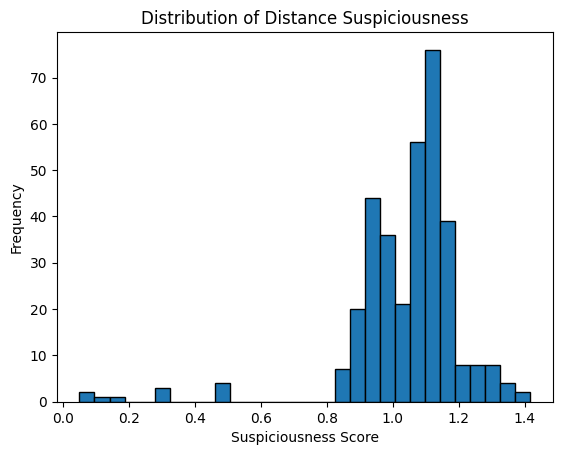

In [15]:
plt.hist(cleaned_housing_data['Distance Suspiciousness'], bins=30, edgecolor='black')
# Add titles and labels
plt.title('Distribution of Distance Suspiciousness')
plt.xlabel('Suspiciousness Score')
plt.ylabel('Frequency')

# Show the plot
plt.show()

In [16]:
# Check for duplicate column names
print("Checking for duplicate column names...")
if cleaned_housing_data.columns.duplicated().any():
    print("Duplicate columns detected:")
    # Get a list of all columns with duplicates
    duplicate_columns = cleaned_housing_data.columns[cleaned_housing_data.columns.duplicated()].tolist()
    print("Duplicate columns:", duplicate_columns)
    
    # Remove duplicates by dropping the duplicated columns
    cleaned_housing_data = cleaned_housing_data.location[:, ~cleaned_housing_data.columns.duplicated()]
    print("Duplicate columns removed. Proceeding with the calculation.")
else:
    print("No duplicate columns found. Proceeding with the calculation.")

Checking for duplicate column names...
No duplicate columns found. Proceeding with the calculation.


In [17]:

housing_data_ratios = cleaned_housing_data.copy()

In [18]:
# Create a new dataframe with calculated columns
df_price_metrics = pd.DataFrame()

# Assuming 'List Price', 'Bedrooms Total', 'Bathrooms Full', 'Bathrooms Total', 'Stories', 'Garage Spaces', 'Living Area', 'Lot Size Acres', 'Year Built' columns exist in your dataset

df_price_metrics['Price per Bedroom'] = cleaned_housing_data['List Price'] / cleaned_housing_data['Bedrooms Total']
df_price_metrics['Price per Full Bathroom'] = cleaned_housing_data['List Price'] / cleaned_housing_data['Bathrooms Full']
df_price_metrics['Price per Total Bathroom'] = cleaned_housing_data['List Price'] / cleaned_housing_data['Bathrooms Total']
df_price_metrics['Price per Story'] = cleaned_housing_data['List Price'] / cleaned_housing_data['Stories']
df_price_metrics['Price per Garage Space'] = cleaned_housing_data['List Price'] / cleaned_housing_data['Garage Spaces']
df_price_metrics['Price per Living Area'] = cleaned_housing_data['List Price'] / cleaned_housing_data['Living Area']
df_price_metrics['Price per Lot Size Acre'] = cleaned_housing_data['List Price'] / cleaned_housing_data['Lot Size Acres']
df_price_metrics['Price per Year Built'] = cleaned_housing_data['List Price'] / cleaned_housing_data['Year Built']

# Display the first few rows of the new dataframe
df_price_metrics.head()

,Price per Bedroom,Price per Full Bathroom,Price per Total Bathroom,Price per Story,Price per Garage Space,Price per Living Area,Price per Lot Size Acre,Price per Year Built
24,847.5,847.5,847.5,847.5,1695.0,1.378049,169500.000000,0.844124
26,540.0,1350.0,1350.0,1350.0,1350.0,1.080865,5869.565217,1.352705
37,500.0,1250.0,1250.0,2500.0,1250.0,1.256281,9259.259259,1.262626
39,1475.0,2212.5,1475.0,2212.5,2212.5,1.812039,44250.000000,2.199304
40,1500.0,2250.0,2250.0,2250.0,4500.0,3.155680,32142.857143,2.273876


In [19]:
df_price_metrics['Price per Story'].fillna(cleaned_housing_data['List Price'], inplace=True)

# Handle Garage Spaces: Instead of 0, fill NaN with the median value
df_price_metrics['Price per Garage Space'].fillna(df_price_metrics['Price per Garage Space'].median(), inplace=True)

# Replace infinity for Price per Acre with the median value
df_price_metrics['Price per Lot Size Acre'].replace([np.inf, -np.inf], np.nan, inplace=True)
df_price_metrics['Price per Lot Size Acre'].fillna(df_price_metrics['Price per Lot Size Acre'].median(), inplace=True)

df_price_metrics.fillna(df_price_metrics.median(), inplace=True)

df_price_metrics.head()

/var/folders/t5/ksv476hn4cq52bmfy8685cnh0000gn/T/ipykernel_14446/2848782618.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_price_metrics['Price per Story'].fillna(cleaned_housing_data['List Price'], inplace=True)
/var/folders/t5/ksv476hn4cq52bmfy8685cnh0000gn/T/ipykernel_14446/2848782618.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediat

,Price per Bedroom,Price per Full Bathroom,Price per Total Bathroom,Price per Story,Price per Garage Space,Price per Living Area,Price per Lot Size Acre,Price per Year Built
24,847.5,847.5,847.5,847.5,1695.0,1.378049,169500.000000,0.844124
26,540.0,1350.0,1350.0,1350.0,1350.0,1.080865,5869.565217,1.352705
37,500.0,1250.0,1250.0,2500.0,1250.0,1.256281,9259.259259,1.262626
39,1475.0,2212.5,1475.0,2212.5,2212.5,1.812039,44250.000000,2.199304
40,1500.0,2250.0,2250.0,2250.0,4500.0,3.155680,32142.857143,2.273876


In [20]:
df_price_metrics


,Price per Bedroom,Price per Full Bathroom,Price per Total Bathroom,Price per Story,Price per Garage Space,Price per Living Area,Price per Lot Size Acre,Price per Year Built
24,847.5,847.5,847.500000,847.5,1695.0,1.378049,169500.000000,0.844124
26,540.0,1350.0,1350.000000,1350.0,1350.0,1.080865,5869.565217,1.352705
37,500.0,1250.0,1250.000000,2500.0,1250.0,1.256281,9259.259259,1.262626
39,1475.0,2212.5,1475.000000,2212.5,2212.5,1.812039,44250.000000,2.199304
40,1500.0,2250.0,2250.000000,2250.0,4500.0,3.155680,32142.857143,2.273876
...,...,...,...,...,...,...,...,...
1727,700.0,700.0,466.666667,700.0,1400.0,1.190476,35000.000000,0.698254
1728,800.0,1200.0,1200.000000,2400.0,1200.0,1.295896,13333.333333,1.199400
1730,650.0,1300.0,866.666667,1300.0,1300.0,1.277641,15294.117647,1.286492
1732,810.0,810.0,540.000000,810.0,1620.0,1.203566,32400.000000,0.807577


In [21]:
# Step 1: Filter the dataset for relevant columns (replace with actual column names if needed)
df_phone_name = raw_housing_data[['Listing Agent', 'Agency Phone']]

# Step 2: Group by 'Phone Number' and aggregate the unique 'Agent Name' values
duplicates = df_phone_name.groupby('Agency Phone')['Listing Agent'].nunique()

# Step 3: Filter for phone numbers that are associated with more than one unique agent name
suspicious_numbers = duplicates[duplicates > 1]

# Step 4: Flag listings that contain suspicious phone numbers
def flag_suspicious_phone(row):
    if row['Agency Phone'] in suspicious_numbers.index:
        return 1  # Flag as suspicious
    return 0  # Not suspicious

# Step 5: Apply the function to the raw_housing_data DataFrame
raw_housing_data['is_phone_suspicious'] = raw_housing_data.apply(flag_suspicious_phone, axis=1)

# Step 6: Display flagged listings
suspicious_phone_listings = raw_housing_data[raw_housing_data['is_phone_suspicious'] == 1]
print(suspicious_phone_listings)


                                            List Number  \
0     gAAAAABm9wKyQ9Jkf67wT775NlUCIiB2uBl4wESoZ5GvSi...   
2     gAAAAABm9wKyuy2g6q3NVvgVVN2exdWKr-5NmAsg3RNetA...   
3     gAAAAABm9wKybWr-f_0vG4kOlej1Gw_MwtKb3AMZPFNdte...   
7     gAAAAABm9wKyPcWtduVoEXOZ5M5vr1Yn80hjl7PyVBwysX...   
9     gAAAAABm9wKyUIBXZBCoQfvfhPyTUQPacxQVXfq2nmD9jm...   
...                                                 ...   
1744  gAAAAABm9wKyrp6dInLa9fa_893eIkk84gRpa6CRHjPCkh...   
1745  gAAAAABm9wKy_Kh_pxh7FOqfUuzhjUAQuSn4K3cfqHvILr...   
1746  gAAAAABm9wKycimdSXA6Mugv0dDA2YGsM2ecai7lGVBfhS...   
1747  gAAAAABm9wKyRw3x6BA06to2n3N-gzrqibmxQCGmG-BK0w...   
1748  gAAAAABm9wKyBFTF5ps5FCcCWCsItB-deJTcWkDDD8p3s5...   

                Agency Phone             Listing Agent  \
0     Agency_Phone_Index_656   Listing_Agent_Index_974   
2     Agency_Phone_Index_658   Listing_Agent_Index_976   
3     Agency_Phone_Index_659   Listing_Agent_Index_977   
7     Agency_Phone_Index_663   Listing_Agent_Index_981   
9

In [22]:
suspicious_words = [
    'urgent', 'alert', 'wire transfer', 'guaranteed', 'free',
    'cash only', 'as seen on', 'limited time', 'don’t miss out',
    'risk-free', 'act now', 'exclusive', 'once in a lifetime',
   'contact now', 'no credit check', 'easy approval','Foreclosure',
     "no deposit required", "move-in specials", "free month rent", "lease takeover", "rent-to-own", 
    "pre-approval needed", "urgent rental", "hurry, limited time offer", "cash only, no checks", 
    "first month free", "no background check", "instant approval", "no credit history needed", 
    "temporary housing", "assume the lease", "short-term rental", "virtual tour only", 
    "sublease opportunity", "guaranteed approval", "utilities included", "all bills paid", 
   "no application fee", "get approved today", "house sitting", "unbelievably low rent", 
    "no lease required", "instant income", "non-refundable deposit", "limited properties available", 
    "you won't believe the price", "exclusive listings", "flexible terms", "unforeseen circumstances", 
    "background check waived", "contact immediately", "first come, first served", "urgent need to rent", 
    "newly renovated", "don’t get left out", "act fast before it’s gone", "scam-free guarantee", 
    "friendly landlord", "best value rental", "quick approval process", "no hassle, no fees", 
    "all-inclusive rental", "hidden gem", "affordable living", "ideal for students", 
    "rent today, move in tomorrow"
]

def flag_suspicious_listings(row):
    # Join relevant columns into one text
    text = f"{row['Features']}".lower()  # Combine and convert to lowercase
    # Check for suspicious words
    for word in suspicious_words:
        if word in text:
            return 1  # Flag as suspicious
    return 0  # Not suspicious

# Assuming Features is the column to check
raw_housing_data['is_suspicious'] = raw_housing_data.apply(flag_suspicious_listings, axis=1)

# Display flagged listings
suspicious_listings = raw_housing_data[raw_housing_data['is_suspicious'] == 1]
print(suspicious_listings)

                                            List Number  \
8     gAAAAABm9wKyhUIXEwyFhhLvpTj0X_0B7qvS_yNAKBOgp6...   
12    gAAAAABm9wKyK87znXWEhuNIwi-d9ktEm5eB_AviuYuh8R...   
14    gAAAAABm9wKyt18LTPCqp5hSIgJ5zQ2R93tF4LryJsQVc-...   
48    gAAAAABm9wKy3YMA1sFaFsJBF53Eg5oOcZbyNvw-1-fcxL...   
58    gAAAAABm9wKyvtOOj5IGCZOf0qG5NqpcUkBxvFxajObtzH...   
...                                                 ...   
1642  gAAAAABm9wKyfVIPxb2l5IFUrCBGl7LR8FjyRb4apyhvvb...   
1694  gAAAAABm9wKyks0AoDGGzVnXjBnx_7KWNBy1zrSb6HYN-0...   
1699  gAAAAABm9wKyWBcFWFBX3z-vy3DFzNUYukOYSq6_nS9n2E...   
1713  gAAAAABm9wKyEI94t_vTCUspjlYZFmf6uZXJ6aEEBM8t0J...   
1735  gAAAAABm9wKy8ywYlhxDrfWqyvBoA2fT2kK_1NH2evjjtG...   

                Agency Phone             Listing Agent  \
8                        NaN   Listing_Agent_Index_982   
12    Agency_Phone_Index_666   Listing_Agent_Index_986   
14    Agency_Phone_Index_667   Listing_Agent_Index_987   
48    Agency_Phone_Index_694  Listing_Agent_Index_1017   
5

In [26]:

# Step 1: Start with the base cleaned DataFrame
final_df = cleaned_housing_data.copy()

# Step 2: Add the new features you created
# Assuming you have DataFrames or Series for these additional features, like df_price_metrics, proximity_scores, etc.

# Example: Add price metrics
final_df = pd.concat([final_df, df_price_metrics], axis=1)

# Example: Add scammy words flag (assuming 'is_suspicious' is a column in the raw_housing_data)
final_df['suspicious_diction'] = raw_housing_data['is_suspicious']

final_df['phone_is_suspicious'] =  raw_housing_data['is_phone_suspicious']
# Step 3: Clean the final DataFrame
# Handle NaN values, infinity, and other inconsistencies
final_df.fillna(final_df.median(), inplace=True)  # Fill NaNs with the median of each column


# Step 4: Check the final DataFrame
final_df.info()  # To see if everything looks good
final_df.head()  # To preview the first few rows


file_path = 'data/final_training_set.csv'

# Check if the file already exists
if not os.path.exists(file_path):
    final_df.to_csv(file_path, index=False)
    print(f"File saved as {file_path}")

<class 'pandas.core.frame.DataFrame'>
Index: 340 entries, 24 to 1745
Data columns (total 29 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   List Price                       340 non-null    int64  
 1   Bedrooms Total                   340 non-null    int64  
 2   Bathrooms Total                  340 non-null    int64  
 3   Living Area                      340 non-null    float64
 4   MLS Area Major                   340 non-null    int64  
 5   Year Built                       340 non-null    int64  
 6   Lot Size Acres                   340 non-null    float64
 7   Days on Market                   340 non-null    int64  
 8   Non-Representative Compensation  340 non-null    float64
 9   Stories Total                    340 non-null    float64
 10  Stories                          340 non-null    float64
 11  Bathrooms Full                   340 non-null    int64  
 12  Bathrooms Half           

In [28]:
# Step 1: Select relevant features for anomaly detection
features = final_df.columns

# Standardize the features
scaler = StandardScaler()

# Step 1: Replace infinite values with NaN
final_df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Step 2: Fill NaN values (e.g., with the median of each column)
final_df.fillna(final_df.median(), inplace=True)

X_scaled = scaler.fit_transform(final_df[features])

In [29]:
# Initialize and fit Isolation Forest model
isolation_forest = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
final_df['isolation_forest_flag'] = isolation_forest.fit_predict(X_scaled)

# Anomalies are flagged as -1
anomalies_if = final_df[final_df['isolation_forest_flag'] == -1]


In [30]:
# Initialize and fit LOF model
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
final_df['lof_flag'] = lof.fit_predict(X_scaled)

# LOF also flags anomalies as -1
anomalies_lof = final_df[final_df['lof_flag'] == -1]


In [31]:
'''# Prepare a label where 0 is normal and 1 is anomaly
final_df['anomaly_label'] = (final_df['suspicious_diction'] == 1).astype(int)

# Prepare the DMatrix for XGBoost
X = final_df[features]
y = final_df['anomaly_label']

dtrain = xgb.DMatrix(X, label=y)

# Train the XGBoost model (we can treat it as a classification problem)
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'max_depth': 3,
    'learning_rate': 0.1,
    'scale_pos_weight': len(y) / y.sum()  # Adjust for class imbalance
}
xgb_model = xgb.train(params, dtrain, num_boost_round=100)

# Predict anomaly scores (using threshold 0.5 to flag anomalies)
final_df['xgboost_flag'] = (xgb_model.predict(dtrain) > 0.5).astype(int)

# Flag XGBoost anomalies
anomalies_xgb = final_df[final_df['xgboost_flag'] == 1]
'''

"# Prepare a label where 0 is normal and 1 is anomaly\nfinal_df['anomaly_label'] = (final_df['suspicious_diction'] == 1).astype(int)\n\n# Prepare the DMatrix for XGBoost\nX = final_df[features]\ny = final_df['anomaly_label']\n\ndtrain = xgb.DMatrix(X, label=y)\n\n# Train the XGBoost model (we can treat it as a classification problem)\nparams = {\n    'objective': 'binary:logistic',\n    'eval_metric': 'logloss',\n    'max_depth': 3,\n    'learning_rate': 0.1,\n    'scale_pos_weight': len(y) / y.sum()  # Adjust for class imbalance\n}\nxgb_model = xgb.train(params, dtrain, num_boost_round=100)\n\n# Predict anomaly scores (using threshold 0.5 to flag anomalies)\nfinal_df['xgboost_flag'] = (xgb_model.predict(dtrain) > 0.5).astype(int)\n\n# Flag XGBoost anomalies\nanomalies_xgb = final_df[final_df['xgboost_flag'] == 1]\n"

In [32]:
# Combine flags: Check if all three models flagged the same listing
final_df['flagged_by_all'] = (
    (final_df['isolation_forest_flag'] == -1) & 
    (final_df['lof_flag'] == -1)) #& 
    # (final_df['xgboost_flag'] == 1)
#)

# Get the listings flagged by all models
anomalies_all_models = final_df[final_df['flagged_by_all']]

# Display the results
anomalies_all_models.head()


,List Price,Bedrooms Total,Bathrooms Total,Living Area,MLS Area Major,Year Built,Lot Size Acres,Days on Market,Non-Representative Compensation,Stories Total,...,Price per Story,Price per Garage Space,Price per Living Area,Price per Lot Size Acre,Price per Year Built,suspicious_diction,phone_is_suspicious,isolation_forest_flag,lof_flag,flagged_by_all
135,6000,2,2,1226.0,261,1985,0.0000,130,0.0,2.0,...,3000.0,6000.0,4.893964,17777.777778,3.022670,0,0,-1,-1,True
159,1750,1,1,1143.0,11,2007,0.0000,49,0.0,20.0,...,1750.0,875.0,1.531059,17777.777778,0.871948,0,0,-1,-1,True
512,1125,3,1,1300.0,75,1944,0.1200,195,10.0,1.0,...,1125.0,1125.0,0.865385,9375.000000,0.578704,0,1,-1,-1,True
797,4700,2,2,1080.0,212,1982,0.0100,55,0.0,7.0,...,4700.0,4700.0,4.351852,470000.000000,2.371342,0,1,-1,-1,True
1058,5250,4,4,2875.0,993,2024,0.1365,16,2.5,2.0,...,2625.0,2625.0,1.826087,38461.538462,2.593874,1,0,-1,-1,True


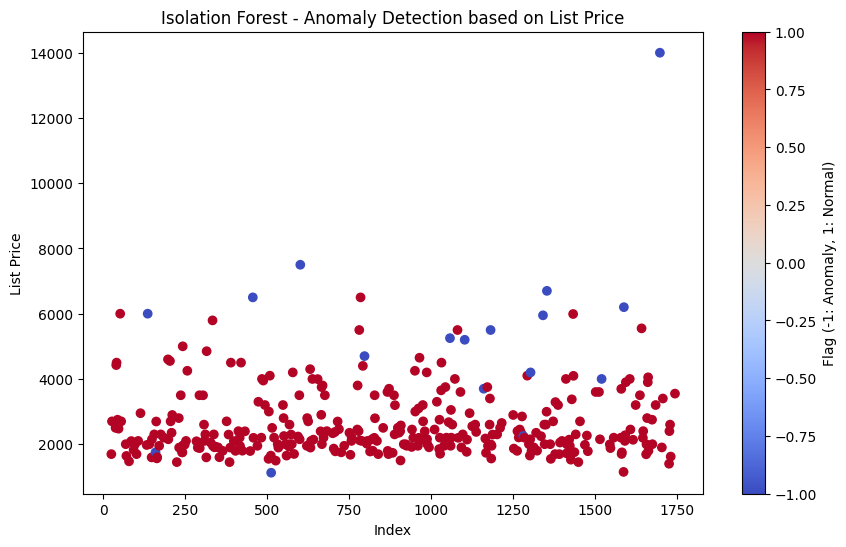

In [33]:
# Isolation Forest Scatter Plot
plt.figure(figsize=(10, 6))
plt.scatter(final_df.index, final_df['List Price'], 
            c=final_df['isolation_forest_flag'], cmap='coolwarm', label='Anomaly Score')
plt.title('Isolation Forest - Anomaly Detection based on List Price')
plt.xlabel('Index')
plt.ylabel('List Price')
plt.colorbar(label='Flag (-1: Anomaly, 1: Normal)')
plt.show()


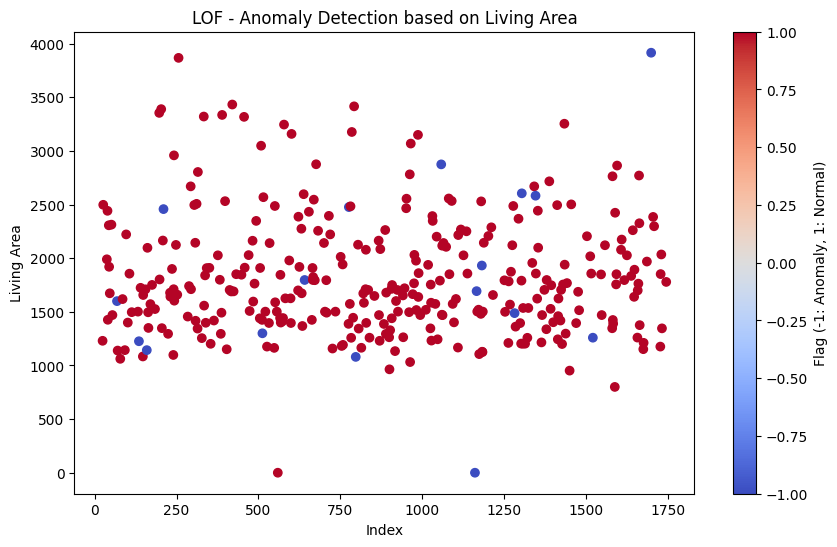

In [34]:
# LOF Scatter Plot
plt.figure(figsize=(10, 6))
plt.scatter(final_df.index, final_df['Living Area'], 
            c=final_df['lof_flag'], cmap='coolwarm', label='Anomaly Score')
plt.title('LOF - Anomaly Detection based on Living Area')
plt.xlabel('Index')
plt.ylabel('Living Area')
plt.colorbar(label='Flag (-1: Anomaly, 1: Normal)')
plt.show()


In [ ]:
'''# XGBoost Probability Scatter Plot
xgboost_probs = xgb_model.predict(dtrain)

plt.figure(figsize=(10, 6))
plt.scatter(final_training_set.index, xgboost_probs, c=(xgboost_probs > 0.5).astype(int), cmap='coolwarm')
plt.title('XGBoost - Predicted Anomaly Probabilities')
plt.xlabel('Index')
plt.ylabel('Anomaly Probability')
plt.colorbar(label='Flag (1: Anomaly, 0: Normal)')
plt.show()'''


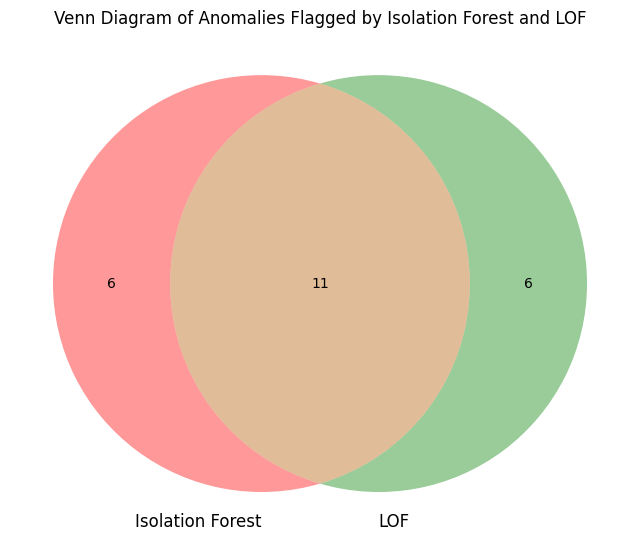

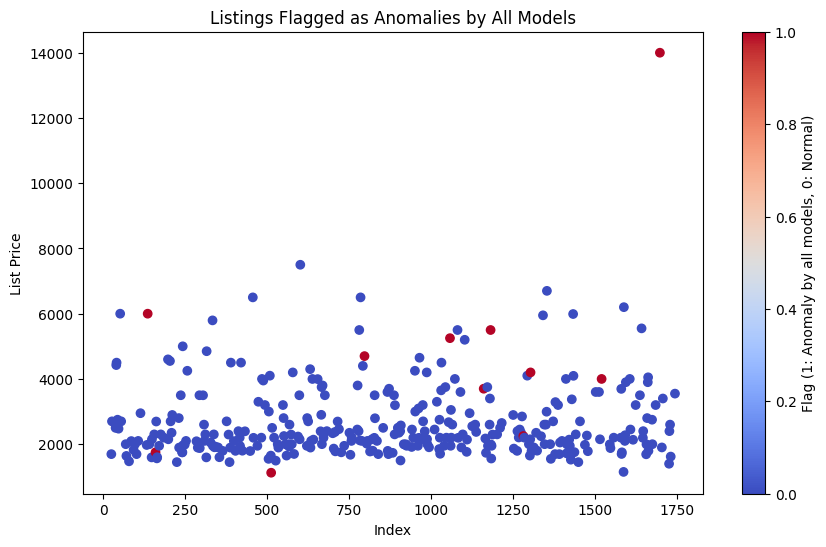

In [35]:
from matplotlib_venn import venn2

# Count how many were flagged by each model
isolation_flags = set(final_df.index[final_df['isolation_forest_flag'] == -1])
lof_flags = set(final_df.index[final_df['lof_flag'] == -1])

# Create a Venn diagram comparing the results of Isolation Forest and LOF
plt.figure(figsize=(8, 8))
venn = venn2([isolation_flags, lof_flags], 
             set_labels=('Isolation Forest', 'LOF'))

plt.title('Venn Diagram of Anomalies Flagged by Isolation Forest and LOF')
plt.show()
plt.figure(figsize=(10, 6))
plt.scatter(final_df.index, final_df['List Price'], 
            c=final_df['flagged_by_all'], cmap='coolwarm')
plt.title('Listings Flagged as Anomalies by All Models')
plt.xlabel('Index')
plt.ylabel('List Price')
plt.colorbar(label='Flag (1: Anomaly by all models, 0: Normal)')
plt.show()



In [36]:
# Get the indices of listings flagged as anomalies by either Isolation Forest or LOF
anomalies_by_either = isolation_flags.union(lof_flags)
anomalies_by_either_list = list(anomalies_by_either)

# Filter the DataFrame to get the listings marked as anomalies by either model
anomalous_listings = final_df.loc[anomalies_by_either_list]

# Print the listings marked as anomalies by either model
print("Listings flagged as anomalies by either Isolation Forest or LOF:")
print(anomalous_listings)

Listings flagged as anomalies by either Isolation Forest or LOF:
      List Price  Bedrooms Total  Bathrooms Total  Living Area  \
512         1125               3                1       1300.0   
641         2140               2                2       1797.0   
1282        2250               4                2       1488.0   
1346        2600               4                3       2583.0   
68          2000               3                2       1600.0   
135         6000               2                2       1226.0   
456         6500               5                3       3318.0   
1161        3700               5                2          0.0   
1354        6700               3                4       2098.0   
776         3800               3                3       2477.0   
1166        2175               4                1       1693.0   
1103        5200               3                2       1620.0   
210         2895               4                4       2458.0   
1304       

(340, 31)


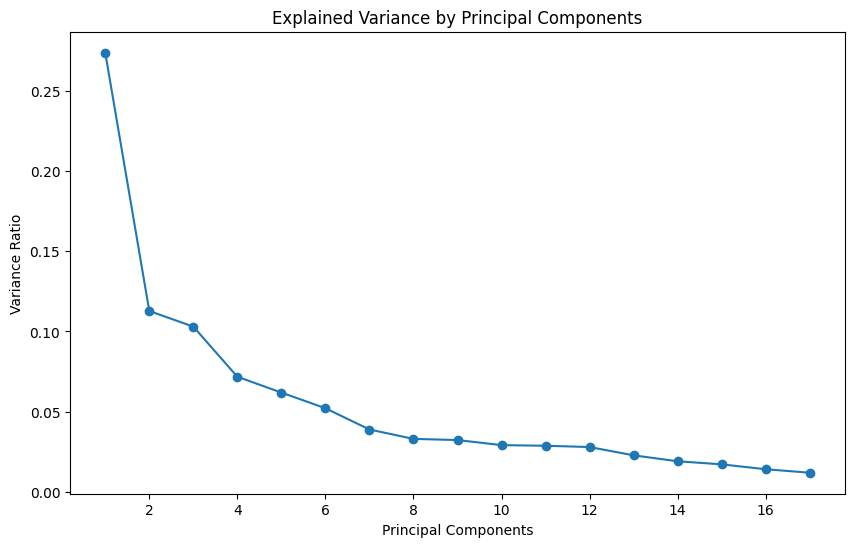

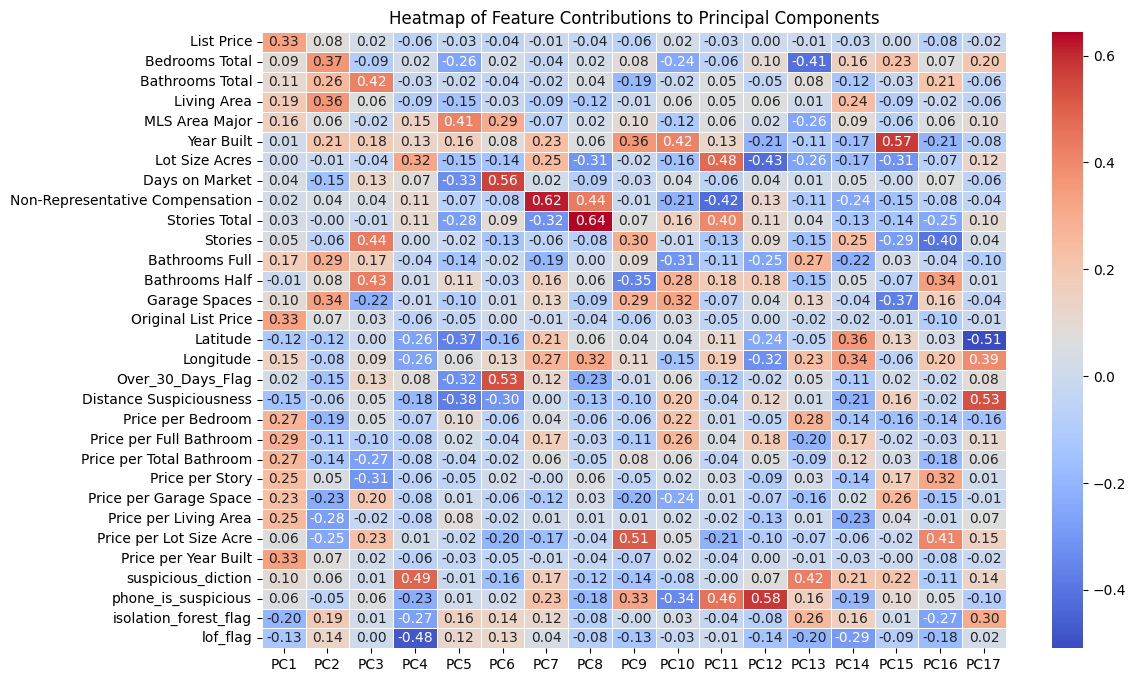

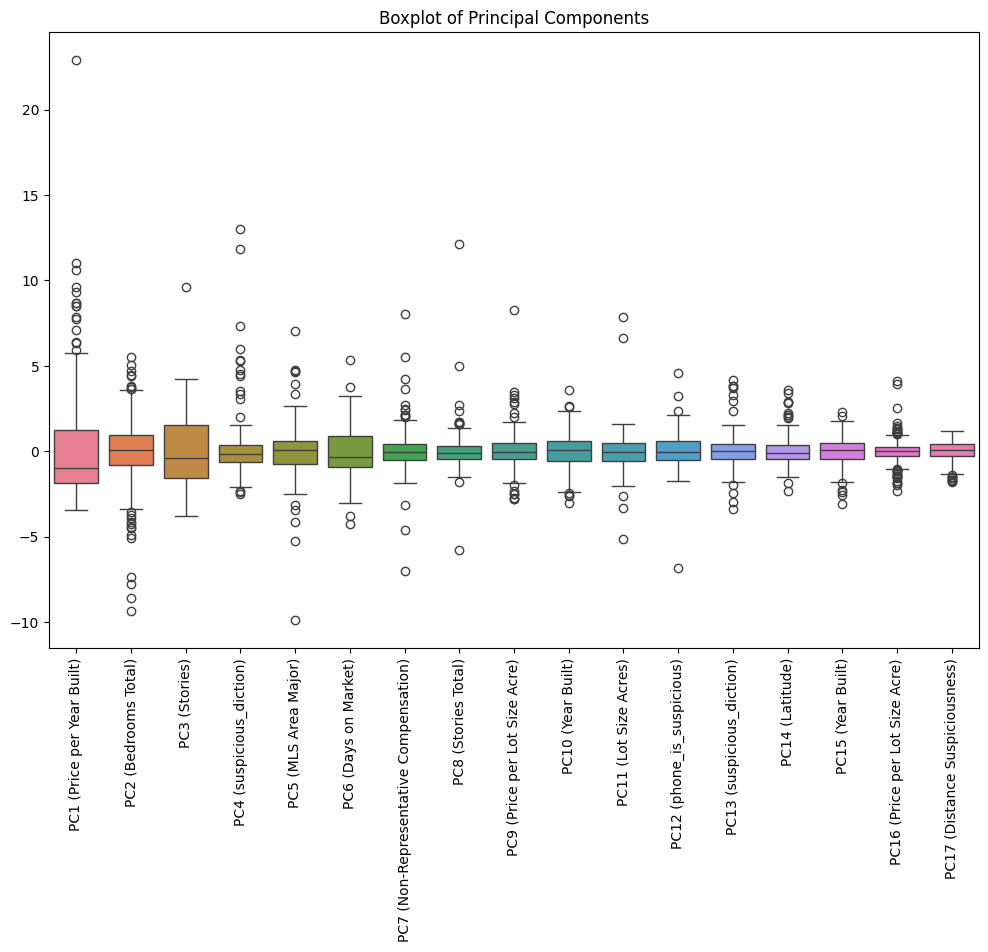

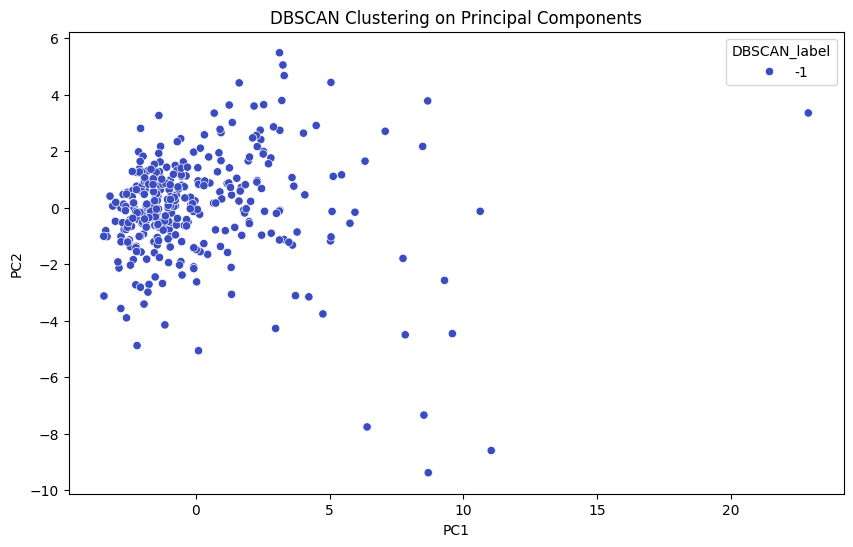

In [37]:

# Assuming final_df is your updated DataFrame
# Step 1: Select only the numerical features from final_df for PCA
numeric_features = final_df.select_dtypes(include=['float64', 'int64']).columns

# Step 2: Extract the numeric features from final_df
X = final_df[numeric_features].values

# Step 3: Standardize the numeric features before applying PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Check the shape of X_scaled to confirm preprocessing
print(X_scaled.shape)

# Step 4: Apply PCA, retaining 95% of the variance
pca = PCA(n_components=0.95)  # Retaining 95% variance

x_pca = pca.fit_transform(X_scaled)  # Perform PCA on scaled data

# Step 5: Create a DataFrame for the PCA-transformed data
pca_columns = [f'PC{i+1}' for i in range(x_pca.shape[1])]

# Get the top contributing features for each principal component
top_features_per_pc = []
for i in range(pca.components_.shape[0]):
    top_feature_index = np.argmax(np.abs(pca.components_[i]))
    top_feature = numeric_features[top_feature_index]
    top_features_per_pc.append(top_feature)

# Create more descriptive principal component labels
pca_columns_descriptive = [f'PC{i+1} ({top_features_per_pc[i]})' for i in range(len(pca_columns))]

pca_df = pd.DataFrame(x_pca, columns=pca_columns)

# Step 6: Visualize the explained variance for each principal component
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o')
plt.title('Explained Variance by Principal Components')
plt.xlabel('Principal Components')
plt.ylabel('Variance Ratio')
plt.show()

# Step 4: Get the loadings (contributions) of each original feature to each principal component
loadings = pca.components_.T  # Transpose to get original features as rows
contributions_df = pd.DataFrame(loadings, index=numeric_features, columns=pca_columns)

# Step 5: Generate a heatmap of the contributions
plt.figure(figsize=(12, 8))
sns.heatmap(contributions_df, cmap='coolwarm', annot=True, fmt='.2f', linewidths=0.5)
plt.title('Heatmap of Feature Contributions to Principal Components')
plt.show()

# Limit to a reasonable number of principal components (e.g., 10 for visualization)
pca_df_limited = pca_df.iloc[:, :17]

# Generate the boxplot
plt.figure(figsize=(12, 8))
sns.boxplot(data=pca_df_limited)

# Fix the xticks and labels
plt.title('Boxplot of Principal Components')
plt.xticks(rotation=90, ticks=np.arange(len(pca_df_limited.columns)), labels=pca_columns_descriptive[:17])
plt.show()


# # Step 6: Boxplot for each principal component
# plt.figure(figsize=(12, 8))
# # pca_df.boxplot()
# sns.boxplot(data=pca_df)

# plt.title('Boxplot of Principal Components')
# plt.xticks(rotation=90, ticks=np.arange(1, len(pca_columns_descriptive) + 1), labels=pca_columns_descriptive)
# plt.show()

#Step 7: Perform DBSCAN on the PCA-transformed data
dbscan = DBSCAN(eps=0.5, min_samples=5)  # You can adjust eps and min_samples based on your data
dbscan_labels = dbscan.fit_predict(x_pca)

# Step 8: Add the DBSCAN labels to the PCA DataFrame
pca_df['DBSCAN_label'] = dbscan_labels

# Step 9: Visualize the DBSCAN results using a scatter plot of the first two principal components
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='DBSCAN_label', data=pca_df, palette='coolwarm')
plt.title('DBSCAN Clustering on Principal Components')
plt.show()

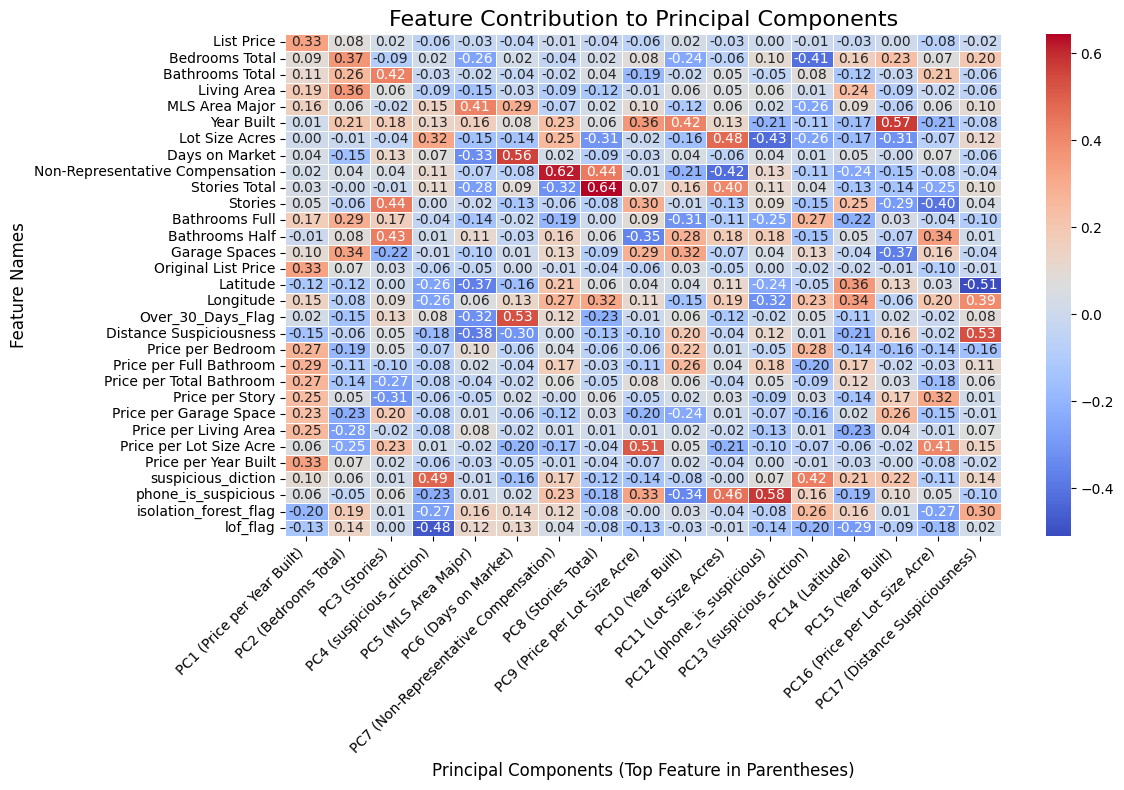

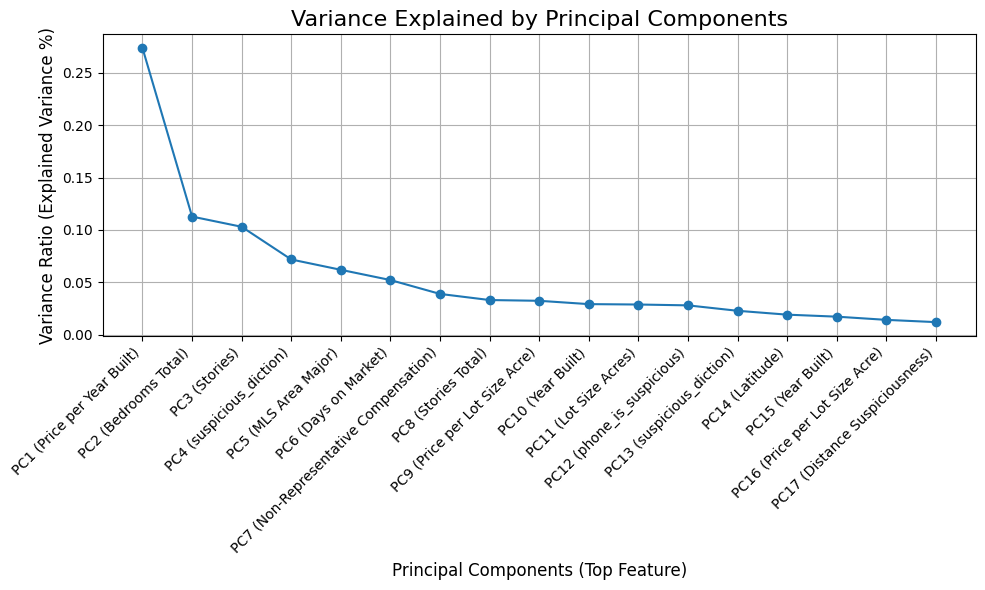

In [39]:
# Get the top contributing features for each principal component
top_features_per_pc = []
for i in range(pca.components_.shape[0]):
    top_feature_index = np.argmax(np.abs(pca.components_[i]))
    top_feature = numeric_features[top_feature_index]
    top_features_per_pc.append(top_feature)

# Create more descriptive principal component labels
pca_columns_descriptive = [f'PC{i+1} ({top_features_per_pc[i]})' for i in range(len(pca_columns))]

# Update the heatmap with descriptive labels
plt.figure(figsize=(12, 8))
sns.heatmap(contributions_df, cmap='coolwarm', annot=True, fmt='.2f', linewidths=0.5)
plt.title('Feature Contribution to Principal Components', fontsize=16)
plt.xlabel('Principal Components (Top Feature in Parentheses)', fontsize=12)
plt.ylabel('Feature Names', fontsize=12)
plt.xticks(ticks=np.arange(len(pca_columns_descriptive)) + 0.5, labels=pca_columns_descriptive, rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

# Use descriptive labels for the principal components in the explained variance plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o')
plt.title('Variance Explained by Principal Components', fontsize=16)
plt.xlabel('Principal Components (Top Feature)', fontsize=12)
plt.ylabel('Variance Ratio (Explained Variance %)', fontsize=12)
plt.xticks(ticks=np.arange(1, len(pca_columns_descriptive) + 1), labels=pca_columns_descriptive, rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()  # Ensure layout doesn't overlap
plt.show()



In [41]:
def estimate_financial_damage(anomalies_df, precision=0.8, scam_success_rate=0.5):
    """
    Estimate financial damages caused by scams based on anomalies.

    Parameters:
    anomalies_df (DataFrame): The dataframe of detected anomalies.
    precision (float): The precision rate of actual scams within anomalies (default=0.8).
    scam_success_rate (float): The success rate of scams succeeding (default=0.5).

    Returns:
    float: Estimated financial damages.
    """
    # Calculate the estimated number of actual scams
    estimated_scams = len(anomalies_df) * precision * scam_success_rate
    
    # Calculate the mean price of the anomalies
    mean_price = anomalies_df['List Price'].mean()
    
    # Estimate total financial damage
    estimated_damage = estimated_scams * mean_price
    
    return estimated_damage

In [43]:
estimate_financial_damage(anomalous_listings)

np.float64(42454.0)